# SwinTransformer 图片分类

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。


SwinTransformer 是微软亚洲研究院在2021年提出的适用于CV领域的一种基于Tranformer的backbone结构。

它是 Shift Window Transformer 的缩写，主要创新点如下。

* 1，分Window进行Transformer计算，将自注意力计算量从输入尺寸的平方量级降低为线性量级。

* 2，使用Shift Window 即窗格偏移技术 来 融合不同窗格之间的信息。(SW-MSA)

* 3，使用类似七巧板拼图技巧 和Mask 技巧 来对 Window偏移后不同大小的窗格进行注意力计算以提升计算效率。

* 4，在经典的QKV注意力公式中引入 Relative Position Bias 项来非常自然地表达位置信息的影响。

* 5，使用Patch Merging技巧来 实现特征图的下采样，类似池化但不易导致信息瓶颈。

* 6，使用不同大小的Window提取不同层次的特征并进行融合。


SwinTransformer虽然采用了Transformer的实现方法，但在整体设计上借鉴了非常多卷积的设计特点，如：局域性，平移不变性，特征图逐渐减小，通道数逐渐增加，多尺度特征融合等。同时它还应用了非常多的trick来弥补Transformer的不足，如效率问题，

B站上有UP主说SwinTransformer是披着Transformer皮的CNN，但毕竟它的内在计算是Transformer，所以我感觉它更像是叠加了卷积Buff的Transformer。

SwinTransformer这个backbone可适用于图片分类，分割，检测等多种任务，拟合能力非常优秀。



下面的范例我们微调 timm库中的 SwinTransformer模型来 做一个猫狗图片分类任务。

看看它的能力到底如何呢？

In [44]:
#!pip install -U  timm, torchkeras 


### 〇，预训练模型

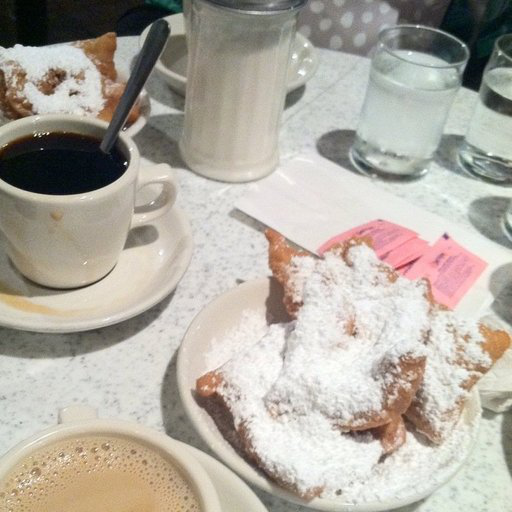

In [1]:
import timm 
from urllib.request import urlopen
from PIL import Image
import timm
import torch 

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))
img 

In [2]:
model = timm.create_model("swin_base_patch4_window7_224.ms_in22k_ft_in1k", pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1), k=5)


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
info = timm.data.ImageNetInfo()
class_codes = info.__dict__['_synsets']
class_names = [info.__dict__['_lemmas'][x] for x in class_codes]


In [4]:
{class_names[i]:v for i,v in zip(top5_class_indices.tolist()[0],
                                top5_probabilities.tolist()[0])}

{'espresso': 0.1655443161725998,
 'cup': 0.12100766599178314,
 'chocolate sauce, chocolate syrup': 0.11809349805116653,
 'eggnog': 0.06144588068127632,
 'tray': 0.03965265676379204}

In [5]:
img.size 

(512, 512)

In [6]:
transforms(img).shape 

torch.Size([3, 224, 224])

## 一，准备数据

In [9]:
import torch
import shutil 
import os 
data_url = 'https://github.com/lyhue1991/torchkeras/releases/download/v3.7.2/cats_vs_dogs.zip'
data_file = 'cats_vs_dogs.zip'

if not os.path.exists(data_file):
    torch.hub.download_url_to_file(data_url,data_file)
    shutil.unpack_archive(data_file,'datasets')

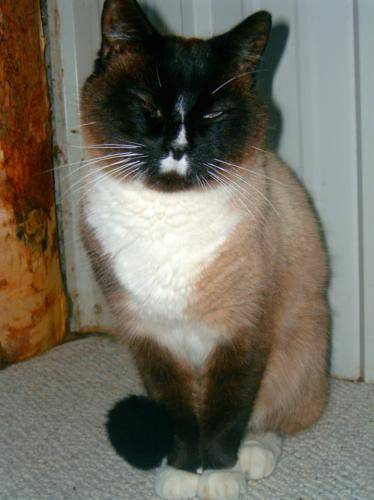

In [10]:
data_path = './datasets/cats_vs_dogs'

train_cats = os.listdir(os.path.join(data_path,"train","cats"))
img = Image.open(os.path.join(os.path.join(data_path,"train","cats",train_cats[0])))
img 


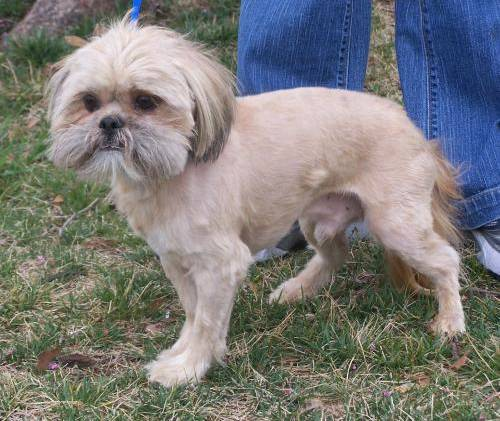

In [11]:
train_dogs = os.listdir(os.path.join(data_path,"train","dogs"))
img = Image.open(os.path.join(os.path.join(data_path,"train","dogs",train_dogs[0])))
img 


In [15]:
from torchvision.datasets import ImageFolder


ds_train = ImageFolder(os.path.join(data_path,"train"),transforms)

ds_val = ImageFolder(os.path.join(data_path,"val"),transforms)


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=4 ,
                                             shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=2,
                                             shuffle=True)

class_names = ds_train.classes

print(len(ds_train))
print(len(ds_val))


2000
995


In [13]:
for batch in dl_val:
    break 
    

In [14]:
batch[1]

tensor([0, 1])

## 二，定义模型

In [16]:
model.reset_classifier(num_classes=2)


In [17]:
model(batch[0])

tensor([[ 0.1698, -0.3366],
        [ 0.4805,  0.1415]], grad_fn=<AddmmBackward0>)

In [18]:
model.cuda();

## 三，训练模型

In [23]:
from torchkeras import KerasModel 
from torchmetrics import Accuracy

loss_fn = torch.nn.CrossEntropyLoss()
metrics_dict = {"acc":Accuracy(task='multiclass',num_classes=2)}

optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-5)

keras_model = KerasModel(model,
                   loss_fn = loss_fn,
                   metrics_dict= metrics_dict,
                   optimizer = optimizer
                  )     


In [24]:
features,labels = batch 

In [25]:
loss_fn(model(features.cuda()),labels.cuda())

tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>)

<<<<<< ⚡️ cuda is used >>>>>>


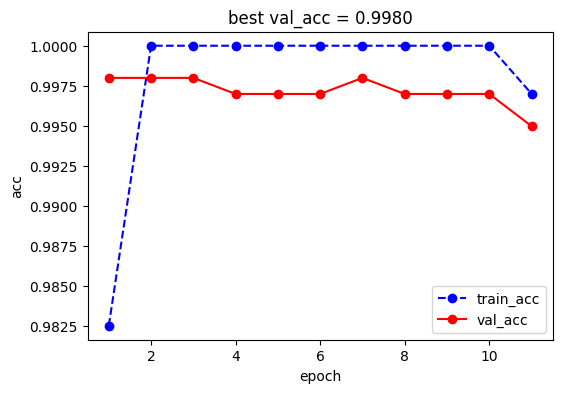

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>>


In [26]:
dfhistory= keras_model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=100, 
                    ckpt_path='checkpoint.pt',
                    patience=10, 
                    monitor="val_acc",
                    mode="max",
                    mixed_precision='no',
                    plot = True,
                    quiet=True
                   )

## 四，评估模型

In [42]:
keras_model.evaluate(dl_val)

100%|████████████████████████████| 498/498 [00:14<00:00, 34.54it/s, val_acc=0.998, val_loss=0.00485]


{'val_loss': 0.004845462673572629, 'val_acc': 0.9979899525642395}

## 五，使用模型

In [30]:
from PIL import Image 
img = Image.open('./datasets/cats_vs_dogs/val/dogs/dog.2005.jpg')

In [37]:
model.eval();

In [38]:
model(transforms(img)[None,...].cuda()).softmax(axis=1)

tensor([[1.1537e-04, 9.9988e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## 六，保存模型

In [45]:
torch.save(model.state_dict(),'swin_transformer.pt') 

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)